# Notebook for Programming in Problem 3
Welcome to the programming portion of the assignment! Each assignment throughout the semester will have a written portion and a programming portion. We will be using [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), so if you have never used it before, take a quick look through this introduction: [Working with Google Colab](https://docs.google.com/document/d/1LlnXoOblXwW3YX-0yG_5seTXJsb3kRdMMRYqs8Qqum4/edit?usp=sharing).

We'll also be programming in Python, which we will assume a basic familiarity with. Python has fantastic community support and we'll be using numerous packages for machine learning (ML) and natural language processing (NLP) tasks.

## Learning Objectives
In this problem, we will use [PyTorch](https://pytorch.org/) to implement feedforward neural networks (FFNNs) and long short-term memory (LSTM) for named entity recognition (NER). We will use the same dataset as in Assignment #2.

## Writing Code
Look for the keyword "TODO" and fill in your code in the empty space.
Feel free to change function signatures, but be careful that you might need to also change how they are called in other parts of the notebook.

## Use GPUs in Colab

GPUs are not strictly necessary for this assignment, but they will accerlerate your experiments and may be helpful for your final project. To enable the free GPU provided by Colab, just go to **Edit > Notebook settings** and select **GPU** as **Hardware accelerator**. To test your GPU, run the `nvidia-smi` command.

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


You should see a table summarizing the current status of the GPU, including the model, power consumption, GPU memory usage, etc. However, Colab does not guarantee which model you will get. We tested the assignment successfully on Tesla T4 but had some problems on other GPUs. **Please make sure you get a Tesla T4** by checking the output of `nvidia-smi`. We empirically observe that you are more likely to get a T4 **with your Princeton account**.

If you are still unable to get a T4. You have 3 options:
1. Reload the page until you get one.
2. Proceed with other GPUs. They should work as long as Colab does not crash when executing code.
3. Disable the GPU and use the CPU for this assignment, which is totally fine.

## Learning PyTorch

This assignment assumes basic familiarity with [PyTorch](https://pytorch.org/), which is a much needed skill for the upcoming Assignment #4, for the final project, and even beyond this course. If you aren't familiar with PyTorch, don't worry, it's a great time to start now! Here are some resources to help you get started. You may also find plenty of them online.

* We will cover PyTorch in the precept on 3/18. Watch the video on Canvas if you are not able to make it.
* [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [Learning PyTorch with Examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)


## Installing PyTorch and Other Packages

Install PyTorch using pip. See [https://pytorch.org/](https://pytorch.org/) if you want to install it on your computer.

In [ ]:
!pip install torch torchtext -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


Test if our installation works:

Also install [scikit-learn](https://scikit-learn.org/stable/). We will use it for calculating evaluation metrics such as accuracy and F1 score.

In [ ]:
!pip install -U scikit-learn

Let's import all the packages at once:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab, vocab
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import re
from collections import Counter
from typing import List, Tuple, Dict, Optional, Any

## Feedforward Neural Network (FFNN)

### Data Loading

We will use the same dataset for named entity recognition in Assignment #2. First download the data and take a look at the first 50 lines:

In [ ]:
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a2/eng.train
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a2/eng.val
!cat eng.train | head -n 50

EU NNP I-NP ORG
rejects VBZ I-VP O
German JJ I-NP MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP MISC
lamb NN I-NP O
. . O O

Peter NNP I-NP PER
Blackburn NNP I-NP PER

BRUSSELS NNP I-NP LOC
1996-08-22 CD I-NP O

The DT I-NP O
European NNP I-NP ORG
Commission NNP I-NP ORG
said VBD I-VP O
on IN I-PP O
Thursday NNP I-NP O
it PRP B-NP O
disagreed VBD I-VP O
with IN I-PP O
German JJ I-NP MISC
advice NN I-NP O
to TO I-PP O
consumers NNS I-NP O
to TO I-VP O
shun VB I-VP O
British JJ I-NP MISC
lamb NN I-NP O
until IN I-SBAR O
scientists NNS I-NP O
determine VBP I-VP O
whether IN I-SBAR O
mad JJ I-NP O
cow NN I-NP O
disease NN I-NP O
can MD I-VP O
be VB I-VP O
transmitted VBN I-VP O
to TO I-PP O
sheep NN I-NP O
. . O O

Germany NNP I-NP LOC
's POS B-NP O
representative NN I-NP O


Each line corresponds to a word. Different sentences are separated by an additional line break. Take "EU NNP I-NP ORG" as an example. "EU" is a word. "NNP" and "I-NP" are tags for POS tagging and chunking, which we will ignore. "ORG" is the tag for NER, which is our prediction target. There are 5 possible values for the NER tag: ORG, PER, LOC, MISC, and O.



First, we write a dataloader for loading the dataset into mini-batches used for training the model. See [torch.utils.data](https://pytorch.org/docs/stable/data.html) for how dataloaders work in PyTorch. In short, we typically need to do two things:
1. Define a [map-style dataset](https://pytorch.org/docs/stable/data.html#map-style-datasets) by subclassing [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and overriding 3 methods: `__init__`, `__getitem__`, and `__len__`.
1. Create a [Dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) by calling its constructor. We have to specify the dataset and a few hyperparameters such as batch size.

Most of the work has been done by us. As a simple exercise, try to understand the code and implement `__len__`.

In [ ]:
# A sentence is a list of (word, tag) tuples.
# For example, [("hello", "O"), ("world", "O"), ("!", "O")]
Sentence = List[Tuple[str, str]]


def read_data_file(
    datapath: str,
) -> Tuple[List[Sentence], Dict[str, int], Dict[str, int]]:
    """
    Read and preprocess input data from the file `datapath`.
    Example:
    ```
        sentences, word_cnt, tag_cnt = read_data_file("eng.train")
    ```
    Return values:
        `sentences`: a list of sentences, including words and NER tags
        `word_cnt`: a Counter object, the number of occurrences of each word
        `tag_cnt`: a Counter object, the number of occurences of each NER tag
    """
    sentences: List[Sentence] = []
    word_cnt: Dict[str, int] = Counter()
    tag_cnt: Dict[str, int] = Counter()

    for sentence_txt in open(datapath).read().split("\n\n"):
        if "DOCSTART" in sentence_txt:
            # Ignore dummy sentences at the begining of each document.
            continue
        # Read a new sentence
        sentences.append([])
        for token in sentence_txt.split("\n"):
            w, _, _, t = token.split()
            # Replace all digits with "0" to reduce out-of-vocabulary words
            w = re.sub("\d", "0", w)
            word_cnt[w] += 1
            tag_cnt[t] += 1
            sentences[-1].append((w, t))

    return sentences, word_cnt, tag_cnt

import matplotlib.pyplot as plt

def plot_tag_histogram(tag_cnt: Dict[str, int]):
    tags, counts = zip(*tag_cnt.items())
    plt.figure(figsize=(10, 6))
    plt.bar(tags, counts)
    plt.xlabel('NER Tags')
    plt.ylabel('Counts')
    plt.title('Histogram of NER Tag Counts')
    plt.xticks(rotation=45)
    plt.show()


## Implement the `__len__` function below **(1 point)**

In [ ]:

class FixedWindowDataset(Dataset):
    """
    Each data example is a word, its NER tag (the target), and a fixed window centered around it (the input).
    """

    def __init__(
        self,
        datapath: str,
        window_size: int,
        words_vocab: Optional[Vocab] = None,
        tags_vocab: Optional[Vocab] = None,
    ) -> None:
        """
        Initialize the dataset by reading from datapath.
        """
        super().__init__()
        self.examples = []
        START = "<START>"
        END = "<END>"
        UNKNOWN = "<UNKNOWN>"

        print("Loading data from %s" % datapath)
        sentences, word_cnt, tag_cnt = read_data_file(datapath)
        plot_tag_histogram(tag_cnt)

        # I tried to explore sentences
        # print(f" first 10 sentences are {sentences[:10]}")

        # Extract windows
        for sent in sentences:
            # Window size = 2
            words = [START for _ in range(window_size)]

            # leeh 3ml 2 start fel words w 2 None fel tags ???
            #
            #  A : 3l4an el window size 2  => 3l4an y3rf ygeeb awl klma w a5r klma

            tags = [None for _ in range(window_size)]
            for w, t in sent:
                words.append(w)
                tags.append(t)
            words.extend([END for _ in range(window_size)])
            tags.extend([None for _ in range(window_size)])
            #  if sentence  Magdy is english  => per  o Org
            #  words [start start magdy is  english end end]   tags = [none none per o org none none ]
            for i, t in enumerate(tags[window_size:-window_size], start=window_size):
                self.examples.append(
                    {
                        "word": words[i],
                        "tag": t,
                        "context": words[i - window_size : i + window_size + 1],
                    }
                )

        print("%d examples loaded." % len(self.examples))

        # set vocabs
        if words_vocab is None:
            words_vocab = vocab(word_cnt, specials=[START, END, UNKNOWN]) # automatically create a vocabulary from words in dataset
            words_vocab.set_default_index(words_vocab[UNKNOWN])
        self.words_vocab = words_vocab
        self.unknown_idx = self.words_vocab[UNKNOWN]
        self.start_idx = self.words_vocab[START]
        self.end_idx = self.words_vocab[END]
        # print(f" words_vocab => {words_vocab}" )
        if tags_vocab is None:
            tags_vocab = vocab(tag_cnt, specials=[]) # automatically create tags vocabulary from tags in dataset
        self.tags_vocab = tags_vocab
        # print(f"tags_vocab => {tags_vocab}")
    def __getitem__(self, idx: int) -> Dict[str, Any]:
        """
        Get the idx'th example in the dataset.
        Convert words and the tag to indexes.
        """
        example = self.examples[idx]
        word = example["word"]
        tag = example["tag"]
        context = example["context"]
        return {
            "word": word,
            "word_idx": self.words_vocab[word],
            "tag": tag,
            "tag_idx": self.tags_vocab[tag],
            "context": context,
            "context_idxs": torch.tensor(
                [self.words_vocab[w] for w in context]
            ),
        }

    def __len__(self) -> int:
        """
        Return the number of examples in the dataset.
        """
        # TODO: Implement this method
        # START HERE
        return len(self.examples)
        # raise NotImplementedError
        # END




In [ ]:
def create_fixed_window_dataloaders(
    batch_size: int, window_size: int, shuffle: bool = True
) -> Tuple[DataLoader, DataLoader, Dict[str, Vocab]]:
    """
    Create the dataloaders for training and validaiton.
    """
    ds_train = FixedWindowDataset("eng.train", window_size)
    # Re-use the vocabulary of the training data
    ds_val = FixedWindowDataset("eng.val", window_size, words_vocab=ds_train.words_vocab, tags_vocab=ds_train.tags_vocab)
    loader_train = DataLoader(
        ds_train, batch_size, shuffle, drop_last=True, pin_memory=True
    )
    loader_val = DataLoader(ds_val, batch_size, pin_memory=True)
    return loader_train, loader_val, ds_train

Let's test our dataloader. Try to understand the output, as it will save your time later.

Loading data from eng.train


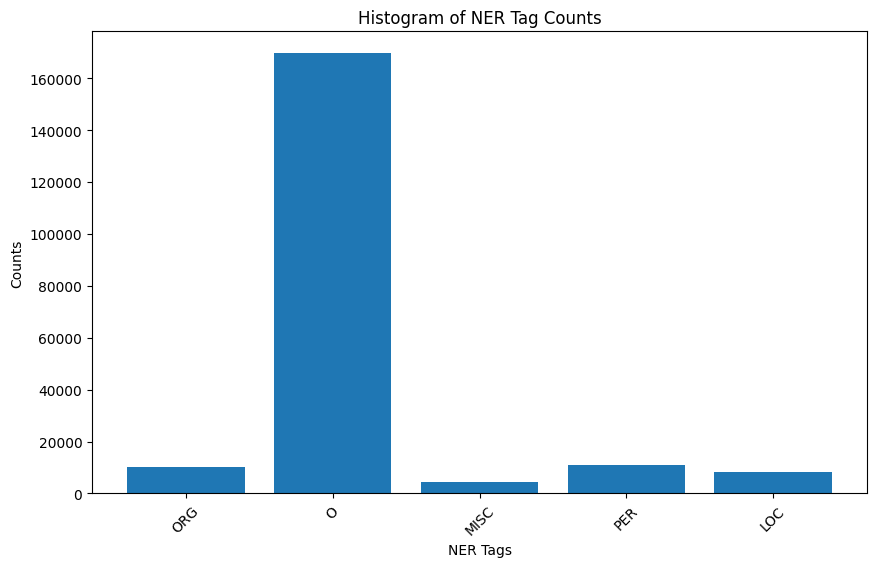

203621 examples loaded.
Loading data from eng.val


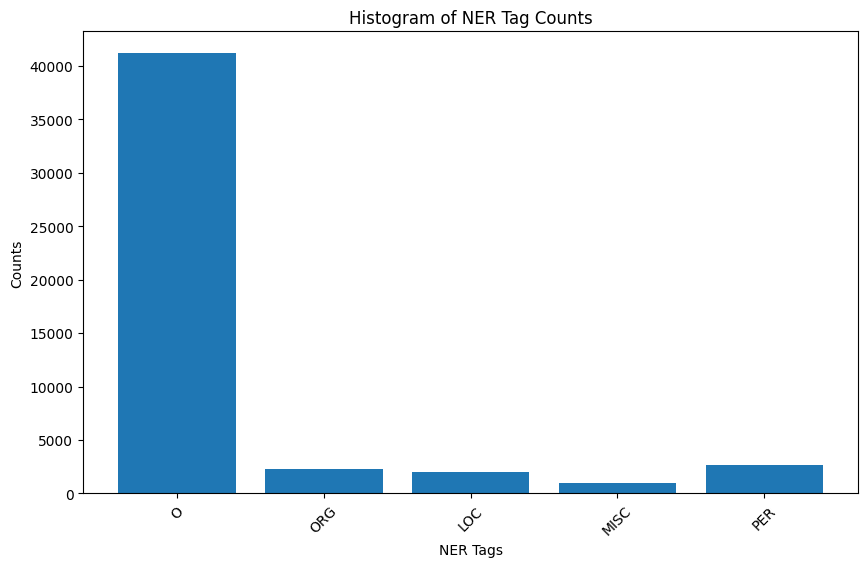

49086 examples loaded.
Iterating on the training data..
{'word': ['EU', 'rejects', 'German'], 'word_idx': tensor([3, 4, 5]), 'tag': ['ORG', 'O', 'MISC'], 'tag_idx': tensor([0, 1, 2]), 'context': [('<START>', '<START>', 'EU'), ('<START>', 'EU', 'rejects'), ('EU', 'rejects', 'German'), ('rejects', 'German', 'call'), ('German', 'call', 'to')], 'context_idxs': tensor([[0, 0, 3, 4, 5],
        [0, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]])}
5
torch.Size([3, 5])
Done!


In [ ]:
def check_fixed_window_dataloader() -> None:
    loader_train, _, _ = create_fixed_window_dataloaders(
        batch_size=3, window_size=2, shuffle=False
    )
    print("Iterating on the training data..")
    for i, data_batch in enumerate(loader_train):
        if i == 0:
            print(data_batch)
            print(len(data_batch["context"]))
            print(data_batch["context_idxs"].shape)
    print("Done!")


check_fixed_window_dataloader()

### Implement the Model **(4 points)**   

Next, let's implement feedforward neural networks following the description of Problem 1 in Assignment #3.

Models in PyTorch are subclasses of [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module). You have to override `__init__` for initializing the model and `forward` for calculating the forward pass. Checkout this [tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html#) if you are not sure how torch.nn.Module works.

PyTorch provides a wide array of [neural network layers](https://pytorch.org/docs/stable/nn.html) as building blocks for your model. Here are some of them that may be relevant:
* [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding)
* [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
* [torch.sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html#torch.sigmoid) or [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid)

Note a difference with Problem 3 of Assignment #2 is that we do not apply softmax when calculatinng $\hat{y}^{(t)}$. Instead, we leave what softmax does to the loss function [F.cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.cross_entropy). For details, please see its difference with [F.nll_loss](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.nll_loss).

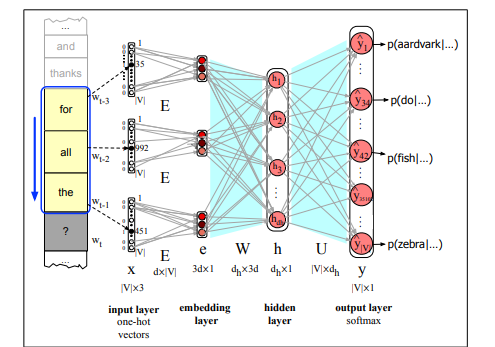

In [ ]:
class FFNN(nn.Module):
    """
    Feedforward Neural Networks for NER
    """

    def __init__(
        self, words_vocab: Vocab, tags_vocab: Vocab, window_size: int, d_emb: int, d_hidden: int
    ) -> None:
        """
        Initialize a two-layer feedforward neural network with sigmoid activation.
        Parameters:
            `words_vocab`: vocabulary of words
            `tags_vocab`: vocabulary of tags
            `window_size`: size of the context window (w in Problem 3 of Assignment #2)
            `d_emb`: dimension of word embeddings (D in Problem 3 of Assignment #2)
            `d_hidden`: dimension of the hidden layer (H in Problem 3 of Assignment #2)
        """
        super().__init__()
        # TODO: Create the word embeddings (nn.Embedding),
        #       the hidden layer and the output layer (nn.Linear).
        # START HERE
        # Awl 7aga t3ala n3ml el embedding

        # num_embeddings (int) – size of the dictionary of embeddings
        # embedding_dim (int) – the size of each embedding vector
        self.word_embeddings = nn.Embedding( len(words_vocab) , d_emb)
        # T3ala ngrb n3ml el hidden layer wel output layer
        #  Important params ==>
        # in_features (int) – size of each input sample

        # out_features (int) – size of each output sample

        # bias (bool) – If set to False, the layer will not learn an additive bias. Default: True
        # bl32l kda 3ayzeen n3rf el ip wel op dimensions btoo3 hidden layer and op layer
        #   (WWcWW)     *  size of each emb vector                ==>hidden ==>  d_hidden (given) ==> Output ==>  Kol el tags 3l4an n maximize 3la a3la wa7d fehoom
        self.hidden_layer = nn.Linear((2 * window_size + 1) * d_emb, d_hidden)
        self.output_layer = nn.Linear(d_hidden, len(tags_vocab))
        # raise NotImplementedError
        # END

    def forward(self, context_idxs: torch.Tensor) -> torch.Tensor:

        """
        Given the word indexes in a context window, predict the logits of the NER tag.
        Parameters:
            `context_idxs`: a batch_size x (2 * window_size + 1) tensor
                          context_idxs[i] contains word indexes in the window of the i'th data example.
        Return values:
            `logits`: a batch_size x 5 tensor (\hat{y}^{(t)} in Problem 3 of Assignment #2, without softmax)
                    logits[i][j] is the output score (before softmax) of the i'th example for tag j.
        """
        # TODO: Implement the forward pass of the two-layer FFNN with sigmoid hidden layer.
        #       Do not apply softmax, since we will use F.cross_entropy as the loss function.
        # START HERE
        #               E   ==>  batchsize * [2w+1 * demb]    ==>       H   ==> batch_size * dhidden  ==>    O  ==> batchsize * no of classes
        # print(context_idxs)
        context_words_embedded = self.word_embeddings(context_idxs) # size ==> batchs size  * (2*w+1) * embdding vector size
        # 5leek fakr enna 2olna en hidden_layer input  7agten bs ==> (batchsize ) * ( (2*w+1) * embdding vector size)
        # print(f"Context words embedded size =>{context_words_embedded.size()}")
        # Reshape the embeddings to fit into the hidden layer
        batch_size, _, _ = context_words_embedded.size()
        # batchsize  , (2w+1) , demb but ana m4 mohtm b a5r 2 so _
        context_words_embedded = context_words_embedded.view(batch_size, -1) #  size ==> [batchs size]  * [(2*w+1) * embdding vector size]
        # It flattens the last two dimensions ( (2 * window_size + 1) and embedding_size) into one dimension
        hidden_output = torch.sigmoid(self.hidden_layer(context_words_embedded))
        # el mafrood hidden output hyb2a ==> batchsize  * d_hidden
        # print(f"hidden output size before sigmoid =>{self.hidden_layer(context_words_embedded).size()}")
        # print(f"hidden output size after sigmoid =>{hidden_output.size()}")

        logits = self.output_layer(hidden_output)
        # print(f"Logits size {logits.size()}")
        # raise NotImplementedError
        # END

        return logits

Optionally, let's do a simple sanity check of your implementation. In `check_ffnn`, we load a batch of data examples and pass it through the FFNN.

In [ ]:
# Some helper code
def get_device() -> torch.device:
    """
    Use GPU when it is available; use CPU otherwise.
    See https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code
    """
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


Loading data from eng.train


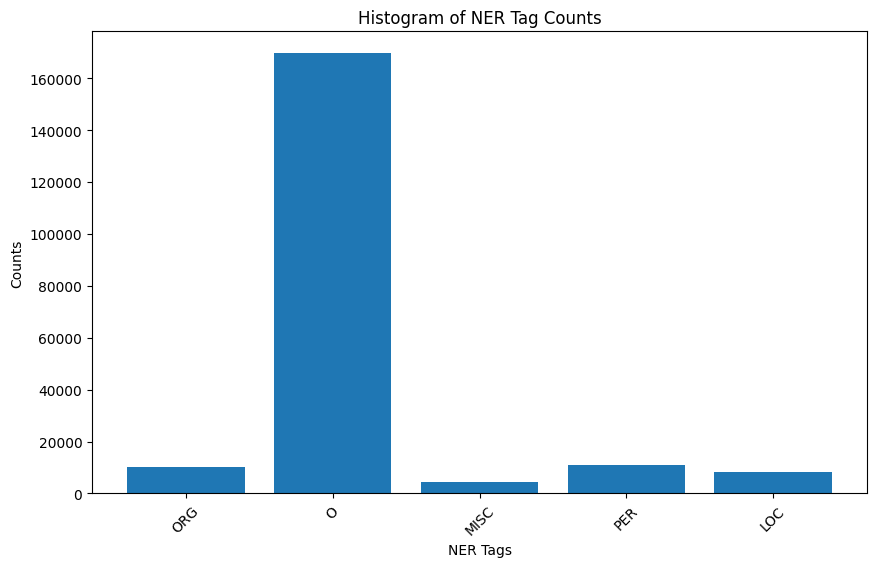

203621 examples loaded.
Loading data from eng.val


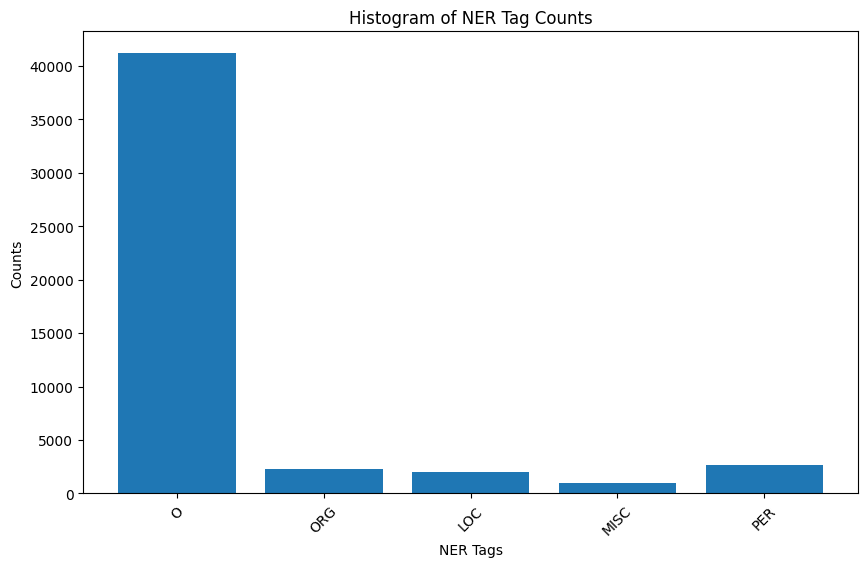

49086 examples loaded.
FFNN(
  (word_embeddings): Embedding(20103, 64)
  (hidden_layer): Linear(in_features=448, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=5, bias=True)
)
Input tensor shape: torch.Size([3, 7])
Output tensor shape: torch.Size([3, 5])


In [ ]:
def check_ffnn() -> None:
  # Hyperparameters
  batch_size = 3
  d_emb = 64
  d_hidden = 128
  window_size = 3
  # Create the dataloaders and the model
  loader_train, _, ds_train = create_fixed_window_dataloaders(batch_size, window_size)
  model = FFNN(ds_train.words_vocab, ds_train.tags_vocab, window_size, d_emb, d_hidden)
  device = get_device()
  model.to(device)
  print(model)
  # Get the first batch
  data_batch = next(iter(loader_train))
  # Move data to GPU
  context_idxs = data_batch["context_idxs"].to(device, non_blocking=True)
  tag_idx = data_batch["tag_idx"].to(device, non_blocking=True)
  # Calculate the model
  print("Input tensor shape:", context_idxs.size())
  logits = model(context_idxs)
  print("Output tensor shape:", logits.size())

check_ffnn()

Loading data from eng.train


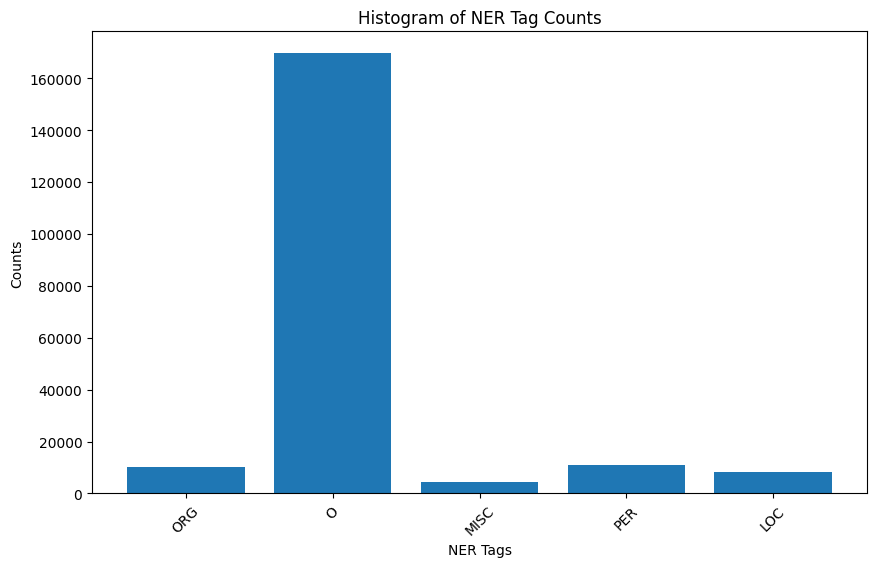

203621 examples loaded.


In [ ]:
ds_train = FixedWindowDataset("eng.train", 3)

### Training and Validation  **(4 points)**   

Having implemented the model, the next step is to implement functions for training and validation.

In [ ]:
def eval_metrics(ground_truth: List[int], predictions: List[int]) -> Dict[str, Any]:
    """
    Calculate various evaluation metrics such as accuracy and F1 score
    Parameters:
        `ground_truth`: the list of ground truth NER tags
        `predictions`: the list of predicted NER tags
    """
    f1_scores = f1_score(ground_truth, predictions, average=None)
    return {
        "accuracy": accuracy_score(ground_truth, predictions),
        "f1": f1_scores,
        "average f1": np.mean(f1_scores),
        "confusion matrix": confusion_matrix(ground_truth, predictions),
    }


def train_ffnn(
    model: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    device: torch.device,
    silent: bool = False,  # whether to print the training loss
) -> Tuple[float, Dict[str, Any]]:
    """
    Train the FFNN model.
    Return values:
        1. the average training loss
        2. training metrics such as accuracy and F1 score
    """
    model.train()
    ground_truth = []
    predictions = []
    losses = []
    report_interval = 100

    for i, data_batch in enumerate(loader):
        context_idxs = data_batch["context_idxs"].to(device, non_blocking=True)
        tag_idx = data_batch["tag_idx"].to(device, non_blocking=True)

        # TODO:
        # 1. Perform the forward pass to calculate the model's output. Save it to the variable "logits".
        # 2. Calculate the loss using the output and the ground truth tags. Save it to the variable "loss".
        # 3. Perform the backward pass to calculate the gradient.
        # 4. Use the optimizer to update model parameters.
        # Caveat: You may need to call optimizer.zero_grad(). Figure out what it does!
        # START HERE
        logits = model.forward(context_idxs)


        loss = F.cross_entropy(logits ,tag_idx )
        # In PyTorch, torch.nn.functional.cross_entropy function combines log_softmax and
        # nll_loss in a single function. So, if you pass raw logits to this function, it internally applies log_softmax on logits before calculating the cross-entropy loss.


        optimizer.zero_grad()
        #used to reset the gradients of all optimized tensors to zero.
        #It's commonly used in conjunction with backpropagation to clear out the gradients before computing new gradients for the next iteration.


        loss.backward() # Computes the gradient of current tensor wrt graph leaves.

        optimizer.step() #Performs a single optimization step (parameter update).


        # END

        losses.append(loss.item())
        ground_truth.extend(tag_idx.tolist())
        predictions.extend(logits.argmax(dim=-1).tolist())

        if not silent and i > 0 and i % report_interval == 0:
            print(
                "\t[%06d/%06d] Loss: %f"
                % (i, len(loader), np.mean(losses[-report_interval:]))
            )

    return np.mean(losses), eval_metrics(ground_truth, predictions)


def validate_ffnn(
    model: nn.Module, loader: DataLoader, device: torch.device
) -> Tuple[float, Dict[str, Any]]:
    """
    Validate the FFNN model.
    Return values:
        1. the average validation loss
        2. validation metrics such as accuracy and F1 score
    """
    model.eval()
    ground_truth = []
    predictions = []
    losses = []

    with torch.no_grad():

        for data_batch in loader:
            context_idxs = data_batch["context_idxs"].to(device, non_blocking=True)
            tag_idx = data_batch["tag_idx"].to(device, non_blocking=True)

            # TODO: Similar to what you did in train_ffnn, but only step 1 and 2.
            # START HERE
            logits = model.forward(context_idxs)

            loss = F.cross_entropy(logits ,tag_idx )

            # END

            losses.append(loss.item())
            ground_truth.extend(tag_idx.tolist())
            predictions.extend(logits.argmax(dim=-1).tolist())

    return np.mean(losses), eval_metrics(ground_truth, predictions)


def train_val_loop_ffnn(hyperparams: Dict[str, Any]) -> None:
    """
    Train and validate the FFNN model for a number of epochs.
    """
    print("Hyperparameters:", hyperparams)
    # Create the dataloaders
    loader_train, loader_val, ds_train = create_fixed_window_dataloaders(
        hyperparams["batch_size"], hyperparams["window_size"]
    )
    # Create the model
    model = FFNN(
        ds_train.words_vocab,
        ds_train.tags_vocab,
        hyperparams["window_size"],
        hyperparams["d_emb"],
        hyperparams["d_hidden"],
    )
    device = get_device()
    model.to(device)
    print(model)
    # Create the optimizer
    optimizer = optim.RMSprop(
        model.parameters(), hyperparams["learning_rate"], weight_decay=hyperparams["l2"]
    )

    # Train and validate
    for i in range(hyperparams["num_epochs"]):
        print("Epoch #%d" % i)

        print("Training..")
        loss_train, metrics_train = train_ffnn(
            model, loader_train, optimizer, device, silent=True
        )
        print("Training loss: ", loss_train)
        print("Training metrics:")
        for k, v in metrics_train.items():
            print("\t", k, ": ", v)

        print("Validating..")
        loss_val, metrics_val = validate_ffnn(model, loader_val, device)
        print("Validation loss: ", loss_val)
        print("Validation metrics:")
        for k, v in metrics_val.items():
            print("\t", k, ": ", v)

    print("Done!")

The `zero_grad()` method in PyTorch's `torch.optim.Optimizer` class is used to reset the gradients of all optimized tensors to zero. It's commonly used in conjunction with backpropagation to clear out the gradients before computing new gradients for the next iteration.

The `set_to_none` parameter allows you to specify whether you want to set the gradients to zero or to `None`. Let's break down the behavior and its use:

1. **Setting gradients to zero**: This is the default behavior. When you call `zero_grad()` without specifying `set_to_none=True`, the gradients are set to zero using `tensor.grad.zero_()`. This means that all gradients are explicitly set to zero values.

2. **Setting gradients to None**: When you call `zero_grad(set_to_none=True)`, the gradients are set to `None` using `tensor.grad = None`. This approach can have a lower memory footprint, especially when dealing with large models and a large number of parameters. However, it comes with certain behavioral changes and considerations:

   - **Behavior when accessing gradients**: If you try to access a gradient after calling `zero_grad(set_to_none=True)`, you'll get `None` instead of zeros. This can affect manual operations you perform on the gradients.
   
   - **Behavior during backward pass**: After calling `zero_grad(set_to_none=True)`, if you perform a backward pass, the `.grad` attributes of parameters that did not receive a gradient during the backward pass will be `None`. This can be useful if you want to differentiate between parameters that received a gradient and those that didn't.
   
   - **Behavior in optimizers**: Some PyTorch optimizers (like `SGD`, `Adam`, etc.) have different behaviors based on whether the gradient is zero or `None`. For instance, if the gradient is zero, it may still perform an optimization step, while if it's `None`, it may skip the step altogether.

In summary, using `zero_grad(set_to_none=True)` can reduce memory usage and provide certain behavioral changes in how gradients are handled, but you should be aware of these changes and ensure they align with your requirements, especially when accessing gradients manually or dealing with different optimizer behaviors.

We are ready to run experiments! Let's train the model for 5 epochs, with `window_size=2`. After each epoch, we perform validation and print the evaluation metrics.

Hyperparameters: {'batch_size': 512, 'd_emb': 64, 'd_hidden': 128, 'window_size': 2, 'num_epochs': 5, 'learning_rate': 0.01, 'l2': 1e-06}
Loading data from eng.train


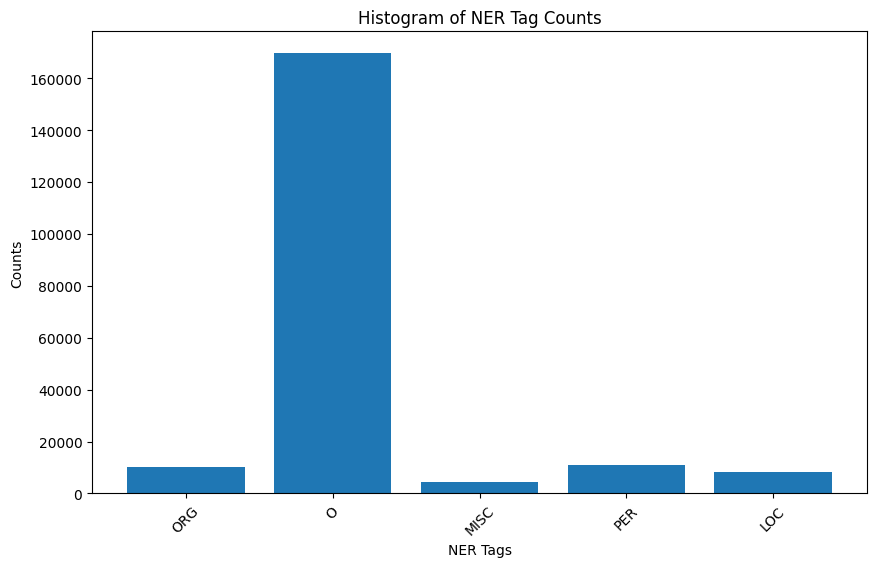

203621 examples loaded.
Loading data from eng.val


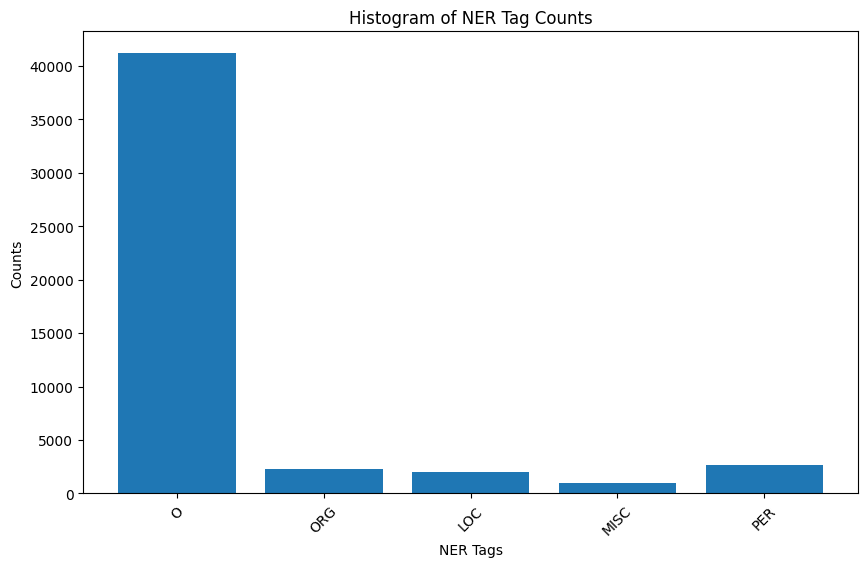

49086 examples loaded.
FFNN(
  (word_embeddings): Embedding(20103, 64)
  (hidden_layer): Linear(in_features=320, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=5, bias=True)
)
Epoch #0
Training..
Training loss:  0.18491500128126265
Training metrics:
	 accuracy :  0.9448402078085643
	 f1 :  [0.72612836 0.97625713 0.6880304  0.83185675 0.80103883]
	 average f1 :  0.8046622923007434
	 confusion matrix :  [[  6749   2041    240    448    529]
 [   890 167391    159    545    297]
 [   293   1207   2716    156    211]
 [   295   1736     61   8873    142]
 [   355   1267    136    204   6323]]
Validating..
Validation loss:  0.13464793619641569
Validation metrics:
	 accuracy :  0.9617813633215173
	 f1 :  [0.79608483 0.9839226  0.77510917 0.87545054 0.87187263]
	 average f1 :  0.8604879535723413
	 confusion matrix :  [[ 1708   318    42    48   134]
 [  127 40881    53    40    63]
 [   48   205   710    11    33]
 [   78   399     0  2186    27]
 [   80  

In [ ]:
train_val_loop_ffnn(
    {
        "batch_size": 512,
        "d_emb": 64,
        "d_hidden": 128,
        "window_size": 2,
        "num_epochs": 5,
        "learning_rate": 0.01,
        "l2": 1e-6,
    }
)

Please re-run with `window_size=1`. How does the final performance change?

Hyperparameters: {'batch_size': 512, 'd_emb': 64, 'd_hidden': 128, 'window_size': 1, 'num_epochs': 5, 'learning_rate': 0.01, 'l2': 1e-06}
Loading data from eng.train


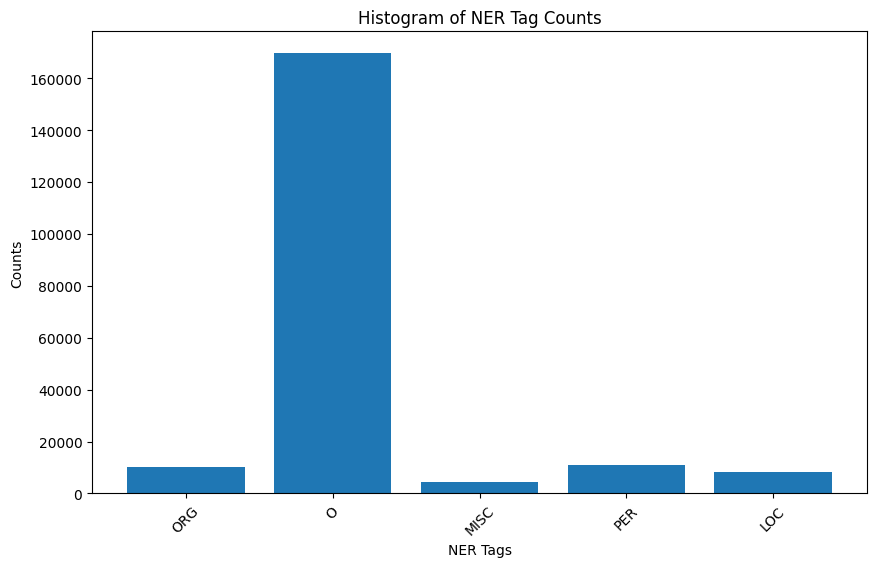

203621 examples loaded.
Loading data from eng.val


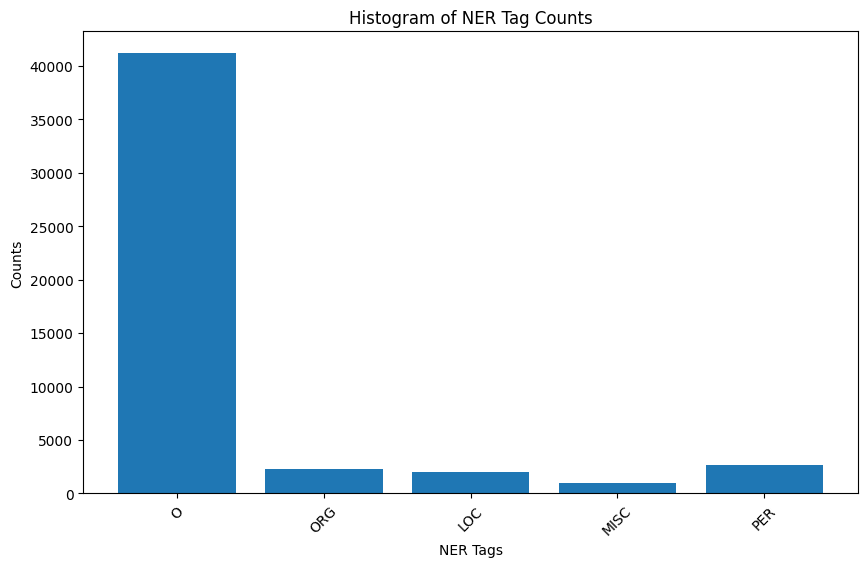

49086 examples loaded.
FFNN(
  (word_embeddings): Embedding(20103, 64)
  (hidden_layer): Linear(in_features=192, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=5, bias=True)
)
Epoch #0
Training..
Training loss:  0.18415537172510882
Training metrics:
	 accuracy :  0.9452436240554156
	 f1 :  [0.74680251 0.97696375 0.71313538 0.80822735 0.79493671]
	 average f1 :  0.8080131405400406
	 confusion matrix :  [[  6890   1918    209    441    553]
 [   539 167328    155    985    268]
 [   271   1087   2834    167    222]
 [   296   1775     47   8802    188]
 [   445   1164    122    278   6280]]
Validating..
Validation loss:  0.1399301285321902
Validation metrics:
	 accuracy :  0.9591329503320702
	 f1 :  [0.78163214 0.98328057 0.77585302 0.85885538 0.8526552 ]
	 average f1 :  0.8504552612918526
	 confusion matrix :  [[ 1566   374    63    84   163]
 [   62 40844    59   118    81]
 [   17   189   739    27    35]
 [   38   377     7  2221    47]
 [   74   

In [ ]:
## TODO: Run again with window size 1
## Keep other hyperparameters fixed
train_val_loop_ffnn(
    {
        "batch_size": 512,
        "d_emb": 64,
        "d_hidden": 128,
        "window_size": 1,
        "num_epochs": 5,
        "learning_rate": 0.01,
        "l2": 1e-6,
    }
)
## END

### Question **(1 point)**

If everything works as expected, you should see the loss decrease and the accuracy increase for both training and validation. The final accuracy can be pretty high; you should probably debug if it's below 92%. However, **is accuracy a good metric for this problem? Why?**. Hint: look at the F1 scores for different tags and the confusion matrix.

**TODO: Please fill in your answer here**


A common complaint about accuracy is that it fails when the classes are imbalanced. For instance, if you get an accuracy of 98%
, that sounds like a high A
 in school, so you might be pretty happy with your performance. However, if the class ratio is 99:1
, then you’re doing worse than you would by always guessing the majority class.

However, accuracy has issues when the classes are naturally balanced, too. In many applications, there are different costs associated with the different mistakes. Accuracy takes away from your ability to play the odds. The typical threshold for a (binary) model that outputs probability values (logistic regression, neural nets, and others) is 0.5
. Accuracy makes a 0.49
 and 0.51
 appear to be different categories while 0.51
 and 0.99
 are the same. I’d be a lot more comfortable making a huge decision based on a probability of 0.99
 than on 0.51!
 Accuracy masks this. In fact, any threshold-based metric like sensitivity, specificity, F1
, positive predictive value, or negative predictive value masks the differences between 0.51
 and 0.99
.
When comparing the FFNN model's performance with window sizes of 2 and 1, several observations can be made:

- Accuracy: The model with window size 2 achieves slightly higher accuracy across all epochs compared to the model with window size 1.
- F1 Scores: The F1 scores, both for individual classes and the average F1 score, are generally higher for the model with window size 2 than for window size 1.
- Loss: The training and validation loss tend to be lower for the model with window size 2 compared to window size 1.
- Confusion Matrix: The confusion matrices show that the model with window size 2 outperforms the model with window size 1 in distinguishing between different classes.

Overall, the model with window size 2 outperforms the model with window size 1 in terms of accuracy, F1 scores, loss, and confusion matrix. This suggests that a larger context window size might be more effective for this NER task.

When considering whether accuracy is a good metric for this problem, it's important to note that NER tasks often involve imbalanced classes. Accuracy alone may be misleading, as it can be high simply by predicting the majority class most of the time. Instead, F1 score, which balances precision and recall, is more suitable for evaluating imbalanced classes. Additionally, the confusion matrix provides valuable insights into the model's performance by showing the breakdown of predictions versus ground truth labels for each class. Therefore, while accuracy is useful, F1 score and the confusion matrix offer a more nuanced understanding of the model's performance in NER tasks.